# Introduction

This notebook was used in order to create the **"DROW3x + validation" curve in Figure 4**.

Note that a lot of code is copy-pasted across notebooks, so you may find some functionality implemented here that is not used, for instance the network is implemented in a way to support late-fusion, which is not used.

In [1]:
from follow_the_drow.datasets import DROW_Dataset
from follow_the_drow.detectors import DrowDetector
from follow_the_drow.utils.file_utils import file_cache_function
from follow_the_drow.utils.drow_utils import linearize, comp_prec_rec_softmax
from follow_the_drow.utils.plot_utils import plot_prec_rec

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Font which got unicode math stuff.
import matplotlib
matplotlib.rcParams["font.family"] = "DejaVu Sans"

# Much more readable plots
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# https://github.com/ipython/ipython/issues/7270#issuecomment-355276432
matplotlib.interactive(False)

# Data loading

**CAREFUL**: `scan` goes right-to-left, i.e. first array value corresponds to "rightmost" laser point. Positive angle is left, negative angle right.

In [3]:
te = DROW_Dataset()
print(f"Dataset includes {len(te.scan_id)} scans and {len(te.det_id)} detections")

Scans from test/*.csv loaded!
Detections from test/*.[wc|wa|wp] loaded!
Detections from test/*.odom2 loaded!
Dataset includes 5 scans and 5 detections


# Model definition

In [4]:
net = DrowDetector.init()
print(f"Number of weights of the detector: {net.parameters_number}")

Loaded weights from /home/pseusys/Documents/repositories/follow_the_drow/library/data_outrigger/include/weights.pth.tar
Number of weights of the detector: 1518918


## On Test

In [5]:
result_conf = {
    "blur_sigma": 2.23409276092903,
    "blur_win": 11,
    "bin_size": 0.04566379529562327,
    "vote_collect_radius": 0.6351825665330302,
    "min_thresh": 0.0027015322261551397,
    "class_weights": [0.89740097838073, 0.3280190481521334, 0.4575675717820713]
}


def process_test_set():
    # TODO: think about it
    seqs, scans, wcs, was, wps = linearize(te.scan_id, te.scans, te.det_id, te.det_wc, te.det_wa, te.det_wp)
    confs, offs = net.forward_all(te)
    return seqs, scans, wcs, was, wps, confs, offs


def create_results(scans, wcs, was, wps, confs, offs, kw):
    return comp_prec_rec_softmax(scans, wcs, was, wps, confs, offs, **kw)

### Figure 4, line "DROW3x + validation" 

Sequences:   0%|          | 0/5 [00:00<?, ?it/s]

Scans:   0%|          | 0/340 [00:00<?, ?it/s]

Scans:   0%|          | 0/248 [00:00<?, ?it/s]

Scans:   0%|          | 0/620 [00:00<?, ?it/s]

Scans:   0%|          | 0/560 [00:00<?, ?it/s]

Scans:   0%|          | 0/660 [00:00<?, ?it/s]

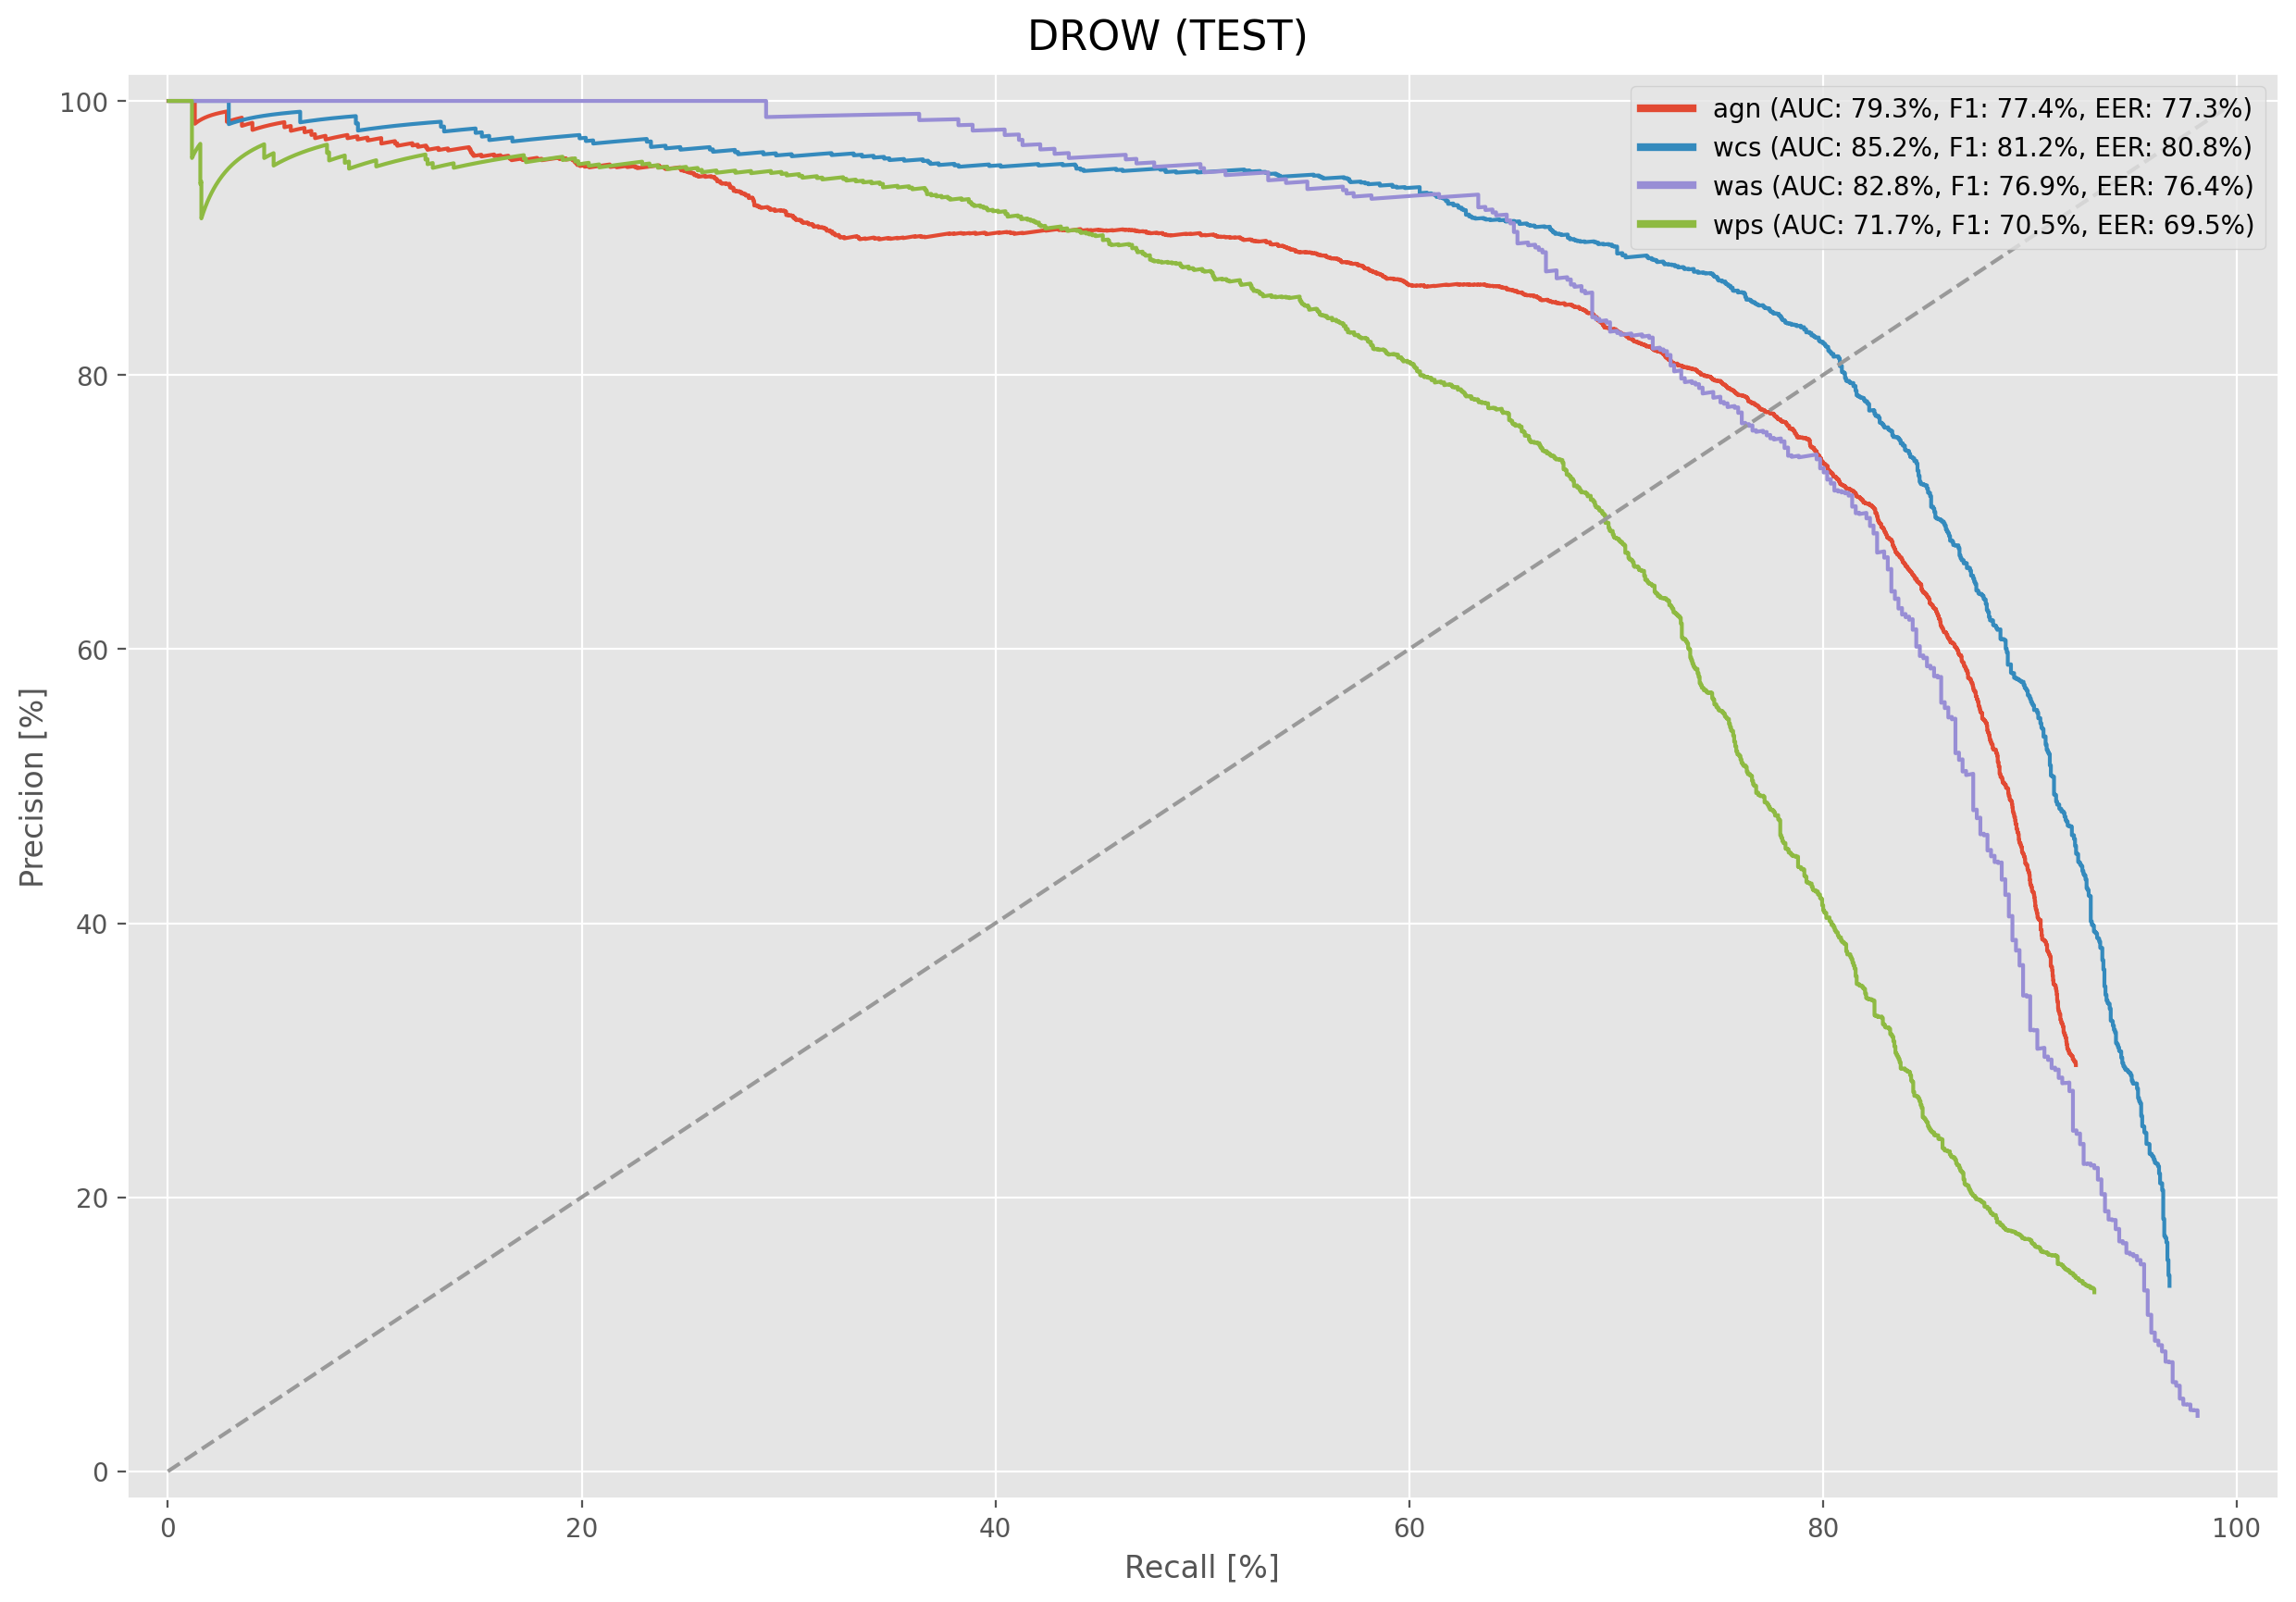

In [6]:
with file_cache_function("test_data_raw.pkl", process_test_set) as (args, recalc):
    with file_cache_function("test_data_normal.pkl", create_results, *args[1:], result_conf, force=recalc) as (results, _):
        fig, _ = plot_prec_rec(*results, title="DROW (TEST)")
        plt.close(fig)

fig

### Smaller evaluation radius (Figure 4, dotted line)

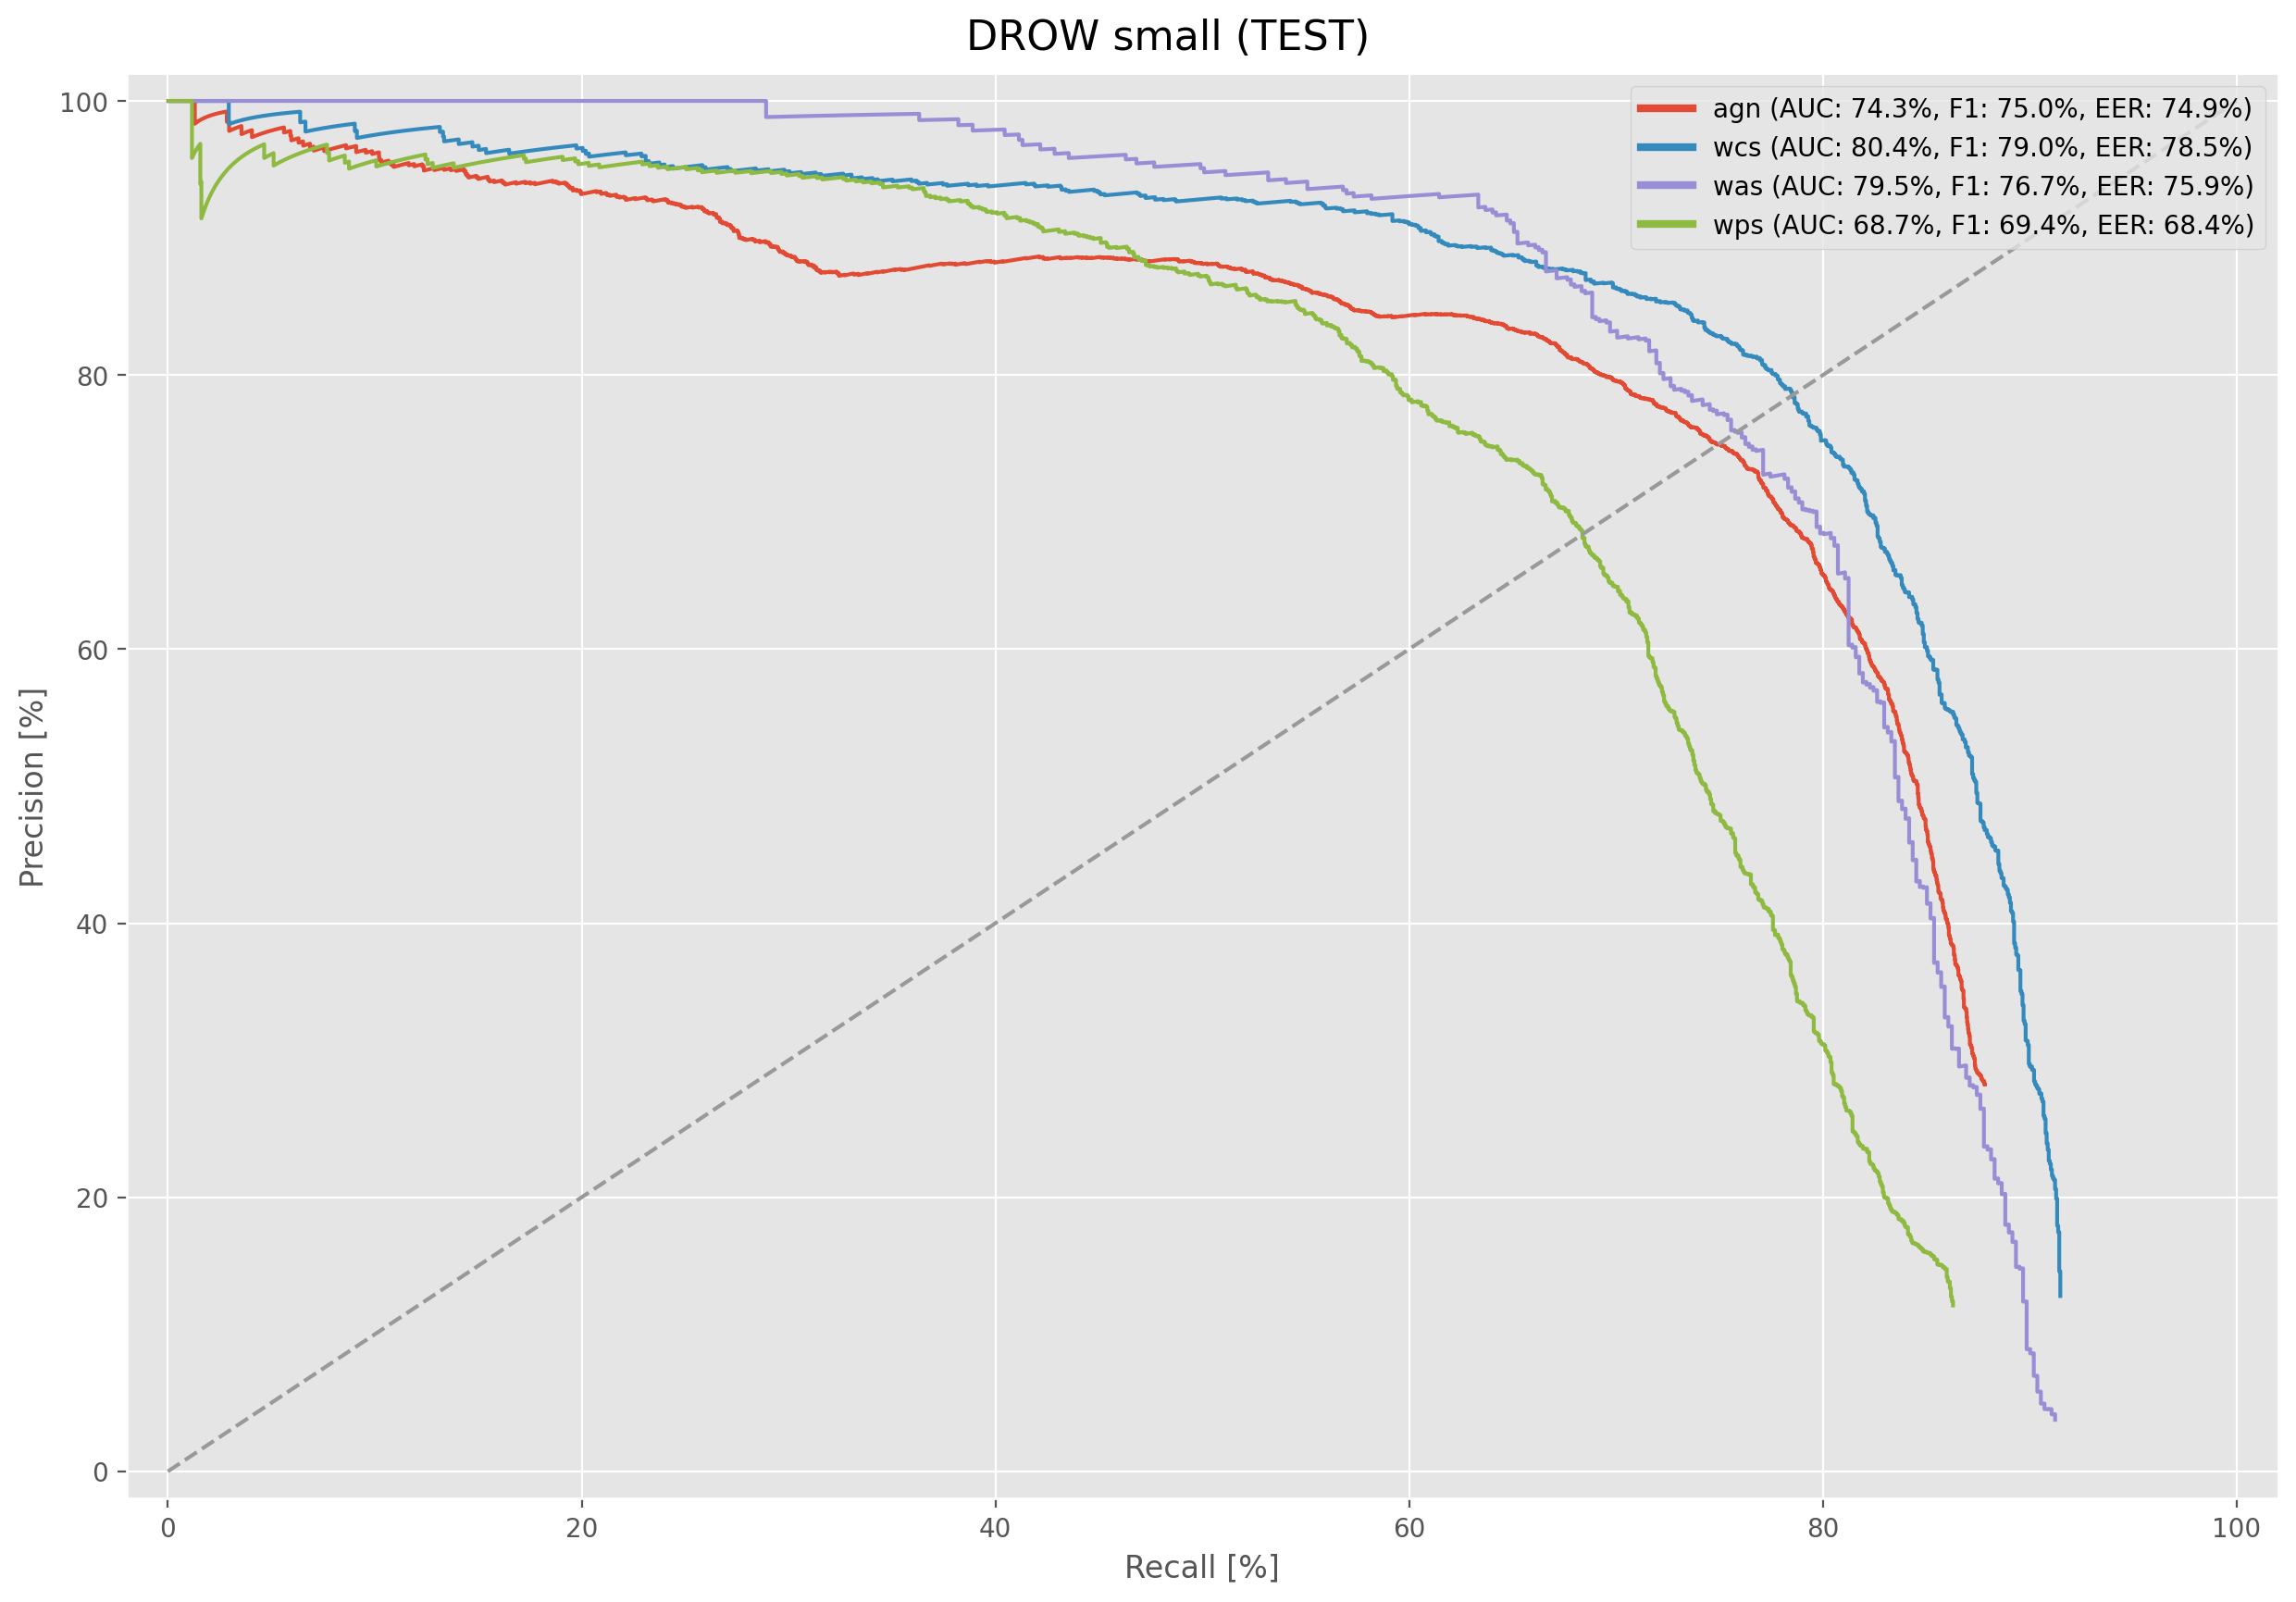

In [7]:
with file_cache_function("test_data_raw.pkl", process_test_set) as (args, recalc):
    conf = {**result_conf, "eval_r": 0.3}
    with file_cache_function("test_data_small.pkl", create_results, *args[1:], conf, force=recalc) as (results, _):
        fig, _ = plot_prec_rec(*results, title="DROW small (TEST)")
        plt.close(fig)

fig